<IPython.core.display.Javascript object>


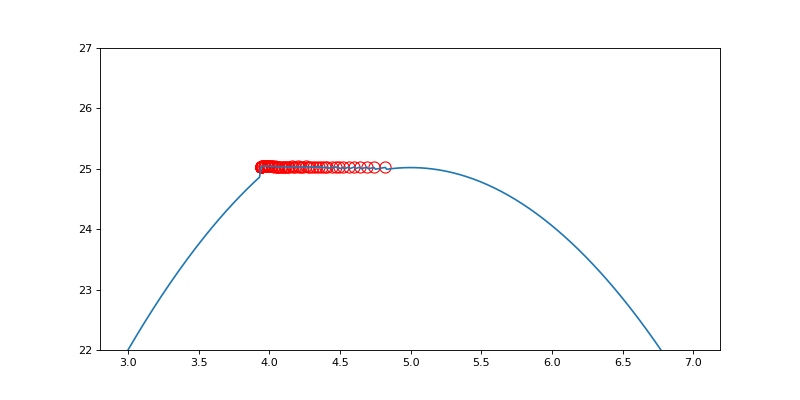

Timing Games Simulation


In [24]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import time
from datetime import datetime
%matplotlib inline
%matplotlib notebook

# Returns the position in group for a given timing n
# optional parameter seed denotes which set of players to sample (-1 for no sampling)
def get_position(n, seed, strats):
    # positions are approximated more accurately by adding 0.5 to the value
    pos = 0.5
    samples = []
    # if using sampling, get the stratgies of the sampled players
    if seed > -1 and sampling > 0:
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        if n > strat:
            pos = pos + 1
    return pos

# Returns ties at timing n
# optional parameter seed denotes which set of players to sample (-1 for no sampling)
def get_tie(n, seed, strats):
    # this is only here to fix rounding comparison issues
    n = round(n, 2)
    
    tie = 0
    samples = []
    # if using sampling, get the strategies of the sampled players
    if seed > -1 and sampling > 0:
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        # more rounding stuff due to float precision errors
        strat = round(strat, 2)
        if n == strat:
            tie = tie + 1
    return tie

# Returns the payoff at timing n
def get_y(n, strats):
    # calculate the timing component
    ux = 1 + (2 * lam * n) - (n * n)
    ties = get_tie(n, -1, strats)
    pos = get_position(n, -1, strats)
    # if there are ties, calculate the average of the position components over the tie range
    if ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((pos+j)/len(strats))/gam) * (1 + ((pos+j)/len(strats))/rho)
        vy = vy/ties
    # otherwise just use the regular formula
    else:
        vy = (1 - (pos/len(strats))/gam) * (1 + (pos/len(strats))/rho)
    return ux * vy

# Loops through all players and moves them if they are ready to move
def update(bubbles, landscape, x, y, strategies):
    # loop over all players
    static_strats = np.copy(strategies)
    best_possible = max(landscape.get_ydata())
    for i in range(len(strategies)):
        # fetch the wait time for the current player
        # toWait = wait_times[i]
        # if the wait time is not zero, decrement it and move to the next player
        # if toWait > 0:
        #     wait_times[i] = wait_times[i] - 1
        #     continue
        chance = theta * (best_possible - get_y(static_strats[i], static_strats))
        chance = max(chance, tick_floor)
        if random.random() > chance:
            continue
        positionsAsSeen = []
        tiesAsSeen = []
        # fetch the positions and ties for every x coordinate
        for val in x:
            positionsAsSeen.append(get_position(val, i, static_strats))
            tiesAsSeen.append(get_tie(val, i, static_strats))
        positionsAsSeen = np.array(positionsAsSeen)
        # calculate the purification value for the current player
        puriVal = 1 - (purification * i/len(strategies))
        # calculate timing component as normal for all x values
        ux = 1 + (2 * lam * x) - (x * x)
        vy = []
        for k in range(len(positionsAsSeen)):
            # for all values in positionsAsSeen, calculate the positional component
            # this math is the same as in get_y
            if sampling > 0:
                if tiesAsSeen[k] == 0:
                    vy.append((1 - (positionsAsSeen[k] * puriVal/sampling)/gam) * (1 + (positionsAsSeen[k] * puriVal/sampling)/rho))
                else:
                    total = 0
                    for j in range(tiesAsSeen[k]):
                        total += (1 - ((positionsAsSeen[k]+j) * puriVal/sampling)/gam) * (1 + ((positionsAsSeen[k]+j) * puriVal/sampling)/rho)
                    total = total/tiesAsSeen[k]
                    vy.append(total)
            # this code is repeated because sampling requires a slightly different calculation
            else:
                if tiesAsSeen[k] == 0:
                    vy.append((1 - (positionsAsSeen[k] * puriVal/num_bots)/gam) * (1 + (positionsAsSeen[k] * puriVal/num_bots)/rho))
                else:
                    total = 0
                    for j in range(tiesAsSeen[k]):
                        total += (1 - ((positionsAsSeen[k]+j) * puriVal/num_bots)/gam) * (1 + ((positionsAsSeen[k]+j) * puriVal/num_bots)/rho)
                    total = total/tiesAsSeen[k]
                    vy.append(total)
        # calculate array of observed payoffs
        y1 = ux * vy
        # find the best observed payoff
        best = max(y1)
        # if there are multiple timings with the best payoff, choose randomly
        indices = [k for k, j in enumerate(y1) if j == best]
        choice = random.choice(indices)
        choice = x[choice]
        # apply trembling
        strategies[i] = choice + round((random.random() * trembling - trembling/2), 2)
        # give the current player a new wait time
        # wait_times[i] = random.randint(0, wait_time)
    # after looping through all players, redraw the landscape
    positions = []
    ties = []
    # find the general position/tie values for all x coordinates
    for val in x:
        positions.append(get_position(val, -1, strategies))
        ties.append(get_tie(val, -1, strategies))
    positions = np.array(positions)
    # recalculate all timing components for the landscape
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    # recalculate all positional values
    for i in range(len(positions)):
        if ties[i] == 0:
            vy.append((1 - (positions[i]/len(strategies))/gam) * (1 + (positions[i]/len(strategies))/rho))
        else:
            total = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
            total = total/ties[i]
            vy.append(total)
    # new landscape payoffs
    y1 = ux * vy
    strat_x = np.sort(strategies)
    strat_y = []
    # calculate bubble positions
    for strat in strat_x:
        strat_y.append(get_y(strat, strategies))
    # redraw
    bubbles.set_xdata(strat_x)
    bubbles.set_ydata(strat_y)
    landscape.set_xdata(x)
    landscape.set_ydata(y1)
    fig.canvas.draw()

# config parameters
# lambda is a reserved word in python so it's shortened here
# cdfmin and max are the rush range
sampling = 5
purification = 0.2
trembling = 0.2
theta = 0.2
tick_floor = 0.001
lam = 5
gam = 3.6
rho = 3
ymin = 22.0
ymax = 27.0
xmin = 3.0
xmax = 7.0
cdfmin = 3.94
cdfmax = 5.0
wait_time = 5
num_bots = 100

# create the plot
plt.ion()
fig = plt.figure(num=None, figsize=(10, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(ymin, ymax)

# calculate the theoretical cdf
cdfx = np.arange(cdfmin, cdfmax, 0.01)
np.round(cdfx, 2)
cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
cdfy = cdfy/2

y_ind = 0
strategies = []
wait_times = []
sample_sets = []
# set initial strategies and sampling
for i in range(num_bots):
    # y_ind is the index in the cdf to compare to
    # we increment it until it is greater than or equal to the percentage of players set so far
    if i/num_bots <= cdfy[y_ind]:
        strategies.append(cdfx[y_ind])
    else:
        while i/num_bots > cdfy[y_ind]:
            y_ind = y_ind + 1
        # there are some rounding issues when we reach the end of the cdf
        # if we reach the end (for the last few players), just use the last value
        if y_ind >= len(cdfy):
            strategies.append(cdfx[len(cdfy)])
        else:
            strategies.append(cdfx[y_ind])
    # strategies.append(random.random() * (xmax - xmin) + xmin)
    # give each player a wait time
    # wait_times.append(random.randint(0, wait_time))
    # give each player an array of random other players to sample
    if sampling > 0:
        to_add = []
        for i in range(sampling):
            val = random.randint(0, num_bots - 1)
            # if we've got this player in the sample set already, try again
            if val in to_add or val == i:
                i = i - 1
            else:
                to_add.append(val)
        sample_sets.append(to_add)
strategies = np.array(strategies)
# more float precision stuff
np.round(strategies, 2)

# set the array of possible x values
x = np.arange(xmin, xmax, 0.01)
positions = []
ties = []
# set up initial values for landscape positions and ties
for val in x:
    positions.append(get_position(val, -1, strategies))
    ties.append(get_tie(val, -1, strategies))
positions = np.array(positions)
# calculate timing component
ux = 1 + (2 * lam * x) - (x * x)
vy = []
# calculate positional component, including ties
for i in range(len(positions)):
    if ties[i] == 0:
        vy.append((1 - (positions[i]/len(strategies))/gam) * (1 + (positions[i]/len(strategies))/rho))
    else:
        total = 0
        for j in range(ties[i]):
            total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
        total = total/ties[i]
        vy.append(total)
y = ux * vy
strat_x = np.sort(strategies)
strat_y = []
# calculate bubble positions
for strat in strat_x:
    strat_y.append(get_y(strat, strategies))
# draw the graph
bubbles, = ax.plot(strat_x, strat_y, 'ro', fillstyle='none', markersize=10)
landscape, = ax.plot(x, y)

# loop indefinitely, updating all players on each pass
while True:
    now = datetime.now()
    update(bubbles, landscape, x, y, strategies)
    after = datetime.now()
    diff = (after - now).total_seconds()
    time.sleep(max((0.5 - diff), 0))
    
print("Timing Games Simulation")